### Import libraries

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score
import streamlit as st


pd.set_option("display.max_columns", None) #untuk menampilkan semua kolom dataframe
pd.set_option("display.max_rows", None) #untuk menampilkan semua baris dataframe


### Load dataset

In [2]:
# Load dataset
df = pd.read_csv("Flight_Price.csv")

# 1. Business Understanding  

Link data : https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data

**Latar Belakang:**  

Harga tiket pesawat sangat fluktuatif karena dipengaruhi berbagai faktor seperti waktu pembelian, rute perjalanan, kelas penerbangan, maskapai, dan waktu keberangkatan. Hal ini menyebabkan:

- Pelanggan kesulitan mengetahui waktu terbaik membeli tiket.

- Maskapai penerbangan dan agen perjalanan (OTA) kesulitan menentukan harga optimal yang kompetitif sekaligus menguntungkan.

**Tujuan proyek:**  

Membangun model machine learning yang mampu memprediksi harga tiket pesawat dengan akurat berdasarkan fitur-fitur berikut:
- Maskapai (airline)
- Kota asal dan tujuan (source_city, destination_city)
- Waktu keberangkatan dan kedatangan (departure_time, arrival_time)
- Jumlah transit (stops)
- Kelas penerbangan (class)
- Lama penerbangan (duration)
- Waktu pembelian sebelum keberangkatan (days_left)

# 2. Data Understanding

Untuk mengetahui detail dari dataset yang akan digunakan, seperti tipe kolom, jumlah data, statistik umum, dan kondisi data secara keseluruhan. Hal ini memastikan data yang digunakan relevan, lengkap, dan berkualitas untuk modeling.

> Informasi Umum Dataset

In [3]:
# Contoh beberapa baris dari dataset
df.tail(10)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300143,300143,Air_India,AI-440,Chennai,Early_Morning,one,Night,Hyderabad,Business,17.42,49,51345
300144,300144,Air_India,AI-539,Chennai,Evening,one,Morning,Hyderabad,Business,18.92,49,51345
300145,300145,Air_India,AI-430,Chennai,Morning,one,Morning,Hyderabad,Business,23.08,49,51345
300146,300146,Air_India,AI-440,Chennai,Early_Morning,one,Morning,Hyderabad,Business,26.83,49,51345
300147,300147,Air_India,AI-569,Chennai,Early_Morning,one,Night,Hyderabad,Business,17.25,49,68739
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585


In [4]:
print("-----------------Informasi umum tentang dataset-----------------\n")
df.info()

-----------------Informasi umum tentang dataset-----------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


> Penjelasan Kolom Data

**Struktur Dataset:**
- Jumlah data: 300,153 baris
- Jumlah kolom: 12
- Tidak ada nilai kosong (non-null values semua)

| Nama Kolom         | Tipe Data   | Deskripsi                                               |
| ------------------ | ----------- | ------------------------------------------------------- |
| `Unnamed`          | Numerik     | Nomer urut biasa dari data, nanti akan di drop          |
| `airline`          | Kategorikal | Nama maskapai                                           |
| `flight`           | Kategorikal | Kode penerbangan, nanti akan di drop                    |
| `source_city`      | Kategorikal | Kota asal keberangkatan                                 |
| `destination_city` | Kategorikal | Kota tujuan penerbangan                                 |
| `departure_time`   | Kategorikal | Waktu keberangkatan (Pagi, Siang, Malam, dll.)          |
| `arrival_time`     | Kategorikal | Waktu kedatangan                                        |
| `stops`            | Kategorikal | Jumlah transit (zero, one, dll.)                        |
| `class`            | Kategorikal | Kelas penerbangan (Economy atau Business)               |
| `duration`         | Numerik     | Durasi penerbangan dalam jam                            |
| `days_left`        | Numerik     | Jumlah hari tersisa dari pemesanan hingga keberangkatan |
| `price`            | Numerik     | harga tiket INR (**Target prediksi**)                       |


> Statistik deskriptif

In [5]:
# Statistik deskriptif
df.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [6]:
df.describe(include='object')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class
count,300153,300153,300153,300153,300153,300153,300153,300153
unique,6,1561,6,6,3,6,6,2
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy
freq,127859,3235,61343,71146,250863,91538,59097,206666


**Statistik Deskriptif:**
- Harga Tiket (price):

    - Harga tiket rata-rata adalah sekitar ₹20,890.
    - Harga tiket terendah adalah ₹1,105 dan tertinggi ₹123,071.
    - Penyebaran data (std dev): cukup besar, sekitar ₹22,698 menunjukkan harga tiket yang variatif.

- Durasi Penerbangan (duration):

    - Rata-rata durasi penerbangan adalah sekitar 12.22 jam.
    - Durasi minimum adalah sekitar 0.83 jam (~50 menit), maksimum mencapai hampir 50 jam.

- Hari sebelum keberangkatan (days_left):
    - Rata-rata pembelian tiket dilakukan sekitar 26 hari sebelum keberangkatan.
    - Rentangnya dari 1 hingga 49 hari.



Jumlah nilai unik di setiap kolom

In [7]:
print("Jumlah nilai unik tiap kolom:")
df.nunique()

Jumlah nilai unik tiap kolom:


Unnamed: 0          300153
airline                  6
flight                1561
source_city              6
departure_time           6
stops                    3
arrival_time             6
destination_city         6
class                    2
duration               476
days_left               49
price                12157
dtype: int64

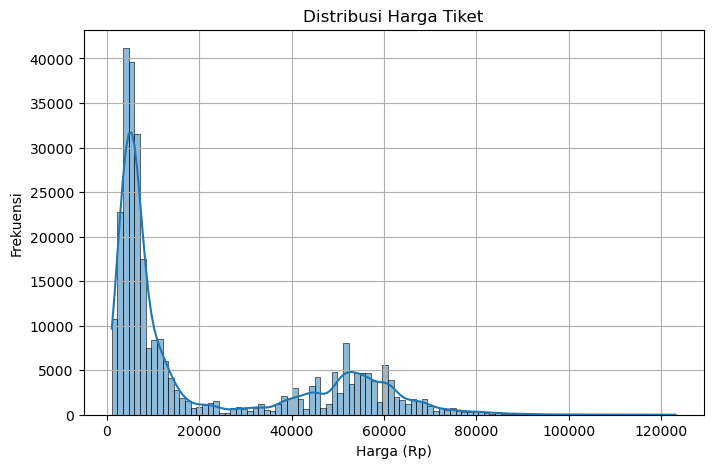

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title('Distribusi Harga Tiket')
plt.xlabel('Harga (Rp)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()


Insight yang didapatkan:  

- Ada dua puncak di histogram harga → kemungkinan karena kelas penerbangan.
- Tidak ada missing values yang kritis.
- Beberapa kategori seperti stops, departure_time, dan class penting untuk prediksi.


Dari histogram harga tiket, terlihat sebagian besar harga tiket berada di kisaran rendah sampai menengah (misal 2.000–7.000). Ada sedikit data di harga sangat tinggi (misal di atas 15.000–30.000).

**Artinya:**

- Ini menunjukkan mayoritas penumpang membeli kelas ekonomi atau rute populer (banyak kompetitor).
- Harga tinggi biasanya untuk kelas bisnis, rute jauh, atau pemesanan sangat mepet.
- Model harus “belajar” dari data yang tidak seimbang (skewed ke harga murah).

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64


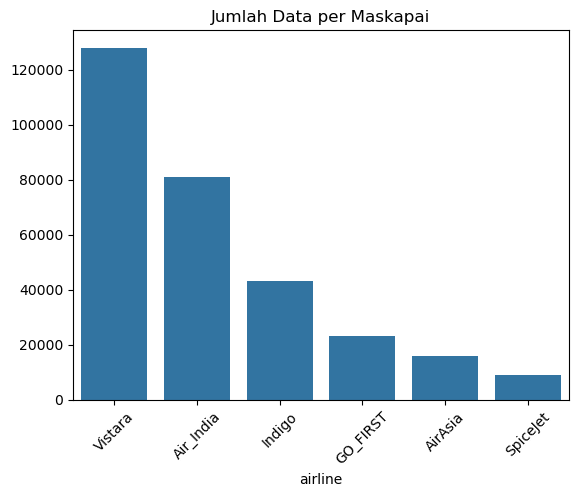

In [9]:
# Jumlah data tiap maskapai
maskapai_count = df['airline'].value_counts()
print(maskapai_count)
sns.barplot(x=maskapai_count.index, y=maskapai_count.values)
plt.xticks(rotation=45)
plt.title('Jumlah Data per Maskapai')
plt.show()

Total jumlah penerbangan

In [10]:
df1=df.groupby(['flight','airline'],as_index=False).count()
df1.airline.value_counts()

airline
Indigo       704
Air_India    218
GO_FIRST     205
SpiceJet     186
Vistara      133
AirAsia      115
Name: count, dtype: int64

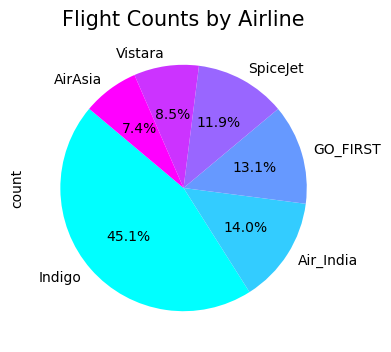

In [11]:
airline_counts=df1.airline.value_counts()
# Create a pie chart
plt.figure(figsize=(4, 4))
df1.airline.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140 , cmap='cool')

# Title and displaying the pie chart
plt.title('Flight Counts by Airline', fontsize=15)
plt.show()

# 3. Data Preparation & Feature Engineering

Tujuan:
- Data Cleaning
- Encode kolom kategorikal
- Transformasi fitur agar siap untuk modeling

### **3a. Data Cleaning & Manipulation**

- Cek missing values & duplikasi
- Hapus kolom tak berguna
- Koreksi tipe data

In [12]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [13]:
# Cek nama kolom
print(df.columns.tolist())

['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']


> Cek missing value

In [14]:
# Cek missing values
print("\nMissing value per kolom:\n")
print(df.isnull().sum())


Missing value per kolom:

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


> Cek data duplikat

In [15]:
len(df.drop_duplicates()) / len(df)

1.0

Tidak ada data duplikat

> Drop kolom yang tidak dibutuhkan

In [16]:
# Drop kolom yang tidak dibutuhkan
df.drop(columns=['Unnamed: 0', 'flight'], inplace=True)

### **3b. Feature Engineering & Encoding**

- Cek missing values & duplikasi
- Hapus kolom tak berguna
- Koreksi tipe data

> Ubah nilai kategorikal `stops` ke angka (zero=0, one=1, two_or_more=2)


In [17]:
# Map jumlah transit
stops_mapping = {
    'zero': 0,
    'one': 1,
    'two_or_more': 2
}
df['stops'] = df['stops'].map(stops_mapping)


> Encode kolom class (Economy = 0, Business = 1)

In [18]:
df['class'] = df['class'].map({'Economy': 0, 'Business': 1})


> One-Hot Encoding untuk kolom kategorikal lain (airline, source_city, dst.)

In [19]:
categorical_columns = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']

# One-hot encode dan gabungkan
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


> Cek hasil akhir

In [20]:
print("Dimensi data setelah preprocessing:", df.shape)
print("Kolom akhir untuk modeling:")
print(df.columns.tolist())


Dimensi data setelah preprocessing: (300153, 30)
Kolom akhir untuk modeling:
['stops', 'class', 'duration', 'days_left', 'price', 'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara', 'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai', 'destination_city_Chennai', 'destination_city_Delhi', 'destination_city_Hyderabad', 'destination_city_Kolkata', 'destination_city_Mumbai', 'departure_time_Early_Morning', 'departure_time_Evening', 'departure_time_Late_Night', 'departure_time_Morning', 'departure_time_Night', 'arrival_time_Early_Morning', 'arrival_time_Evening', 'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night']


In [21]:
# Tampilkan jumlah baris dan kolom
print(f"Jumlah baris data: {df.shape[0]}")
print(f"Jumlah kolom fitur: {df.shape[1]}")

# Tampilkan 5 baris pertama data
print("\nContoh data setelah preprocessing:")
display(df.head())

# Tampilkan semua kolom dengan tipe data
print("\nDaftar kolom dan tipe datanya:")
for col in df.columns:
    print(f"- {col}: {df[col].dtype}")

# Cek apakah masih ada missing values
missing = df.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print("\n⚠️ Missing values ditemukan:")
    print(missing)
else:
    print("\nTidak ada missing values!")


Jumlah baris data: 300153
Jumlah kolom fitur: 30

Contoh data setelah preprocessing:


,stops,class,duration,days_left,price,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
0,0,0,2.17,1,5953,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True
1,0,0,2.33,1,5953,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False
2,0,0,2.17,1,5956,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False
3,0,0,2.25,1,5955,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
4,0,0,2.33,1,5955,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False



Daftar kolom dan tipe datanya:
- stops: int64
- class: int64
- duration: float64
- days_left: int64
- price: int64
- airline_Air_India: bool
- airline_GO_FIRST: bool
- airline_Indigo: bool
- airline_SpiceJet: bool
- airline_Vistara: bool
- source_city_Chennai: bool
- source_city_Delhi: bool
- source_city_Hyderabad: bool
- source_city_Kolkata: bool
- source_city_Mumbai: bool
- destination_city_Chennai: bool
- destination_city_Delhi: bool
- destination_city_Hyderabad: bool
- destination_city_Kolkata: bool
- destination_city_Mumbai: bool
- departure_time_Early_Morning: bool
- departure_time_Evening: bool
- departure_time_Late_Night: bool
- departure_time_Morning: bool
- departure_time_Night: bool
- arrival_time_Early_Morning: bool
- arrival_time_Evening: bool
- arrival_time_Late_Night: bool
- arrival_time_Morning: bool
- arrival_time_Night: bool

Tidak ada missing values!


# 4. Visualisasi dan Analisis Data (EDA Lanjutan)

**Tujuan: analisis visual**

- Distribusi harga berdasarkan maskapai, kelas, waktu beli (days_left), jumlah transit, kota, dst.
- Korelasi fitur numerik (duration, days_left) terhadap harga

In [22]:
# Korelasi fitur numerik
print(df[['price', 'days_left', 'duration']].corr())

              price  days_left  duration
price      1.000000  -0.091949  0.204222
days_left -0.091949   1.000000 -0.039157
duration   0.204222  -0.039157  1.000000


Distribusi Harga Tiket

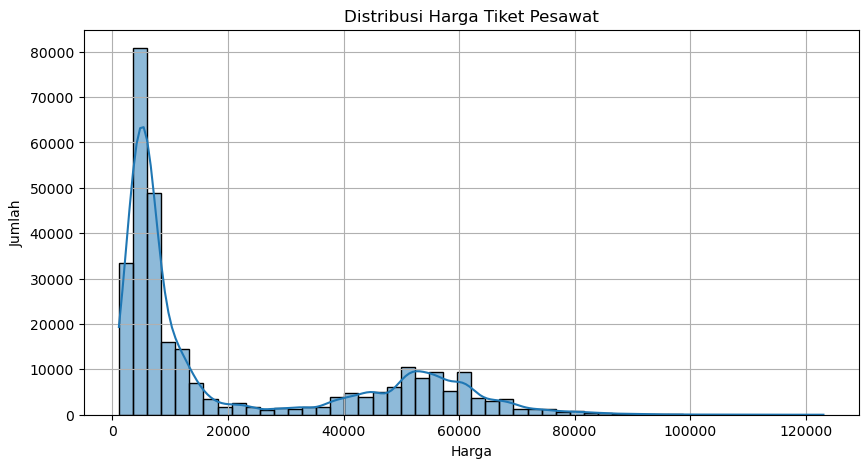

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribusi Harga Tiket Pesawat')
plt.xlabel('Harga')
plt.ylabel('Jumlah')
plt.grid(True)
plt.show()


- Terlihat dua puncak (bimodal) → menunjukkan ada dua segmen harga: Ekonomi & Bisnis

- Harga ekonomi dominan di bawah 20.000, bisnis di atas 40.000  
🔁 Langkah selanjutnya: pertimbangkan membuat 2 model terpisah berdasarkan kelas (class)

Boxplot Harga vs Maskapai

In [24]:
# Perlu kolom airline asli, jadi kita load ulang khusus untuk visualisasi ini
raw_df = pd.read_csv("Flight_Price.csv")

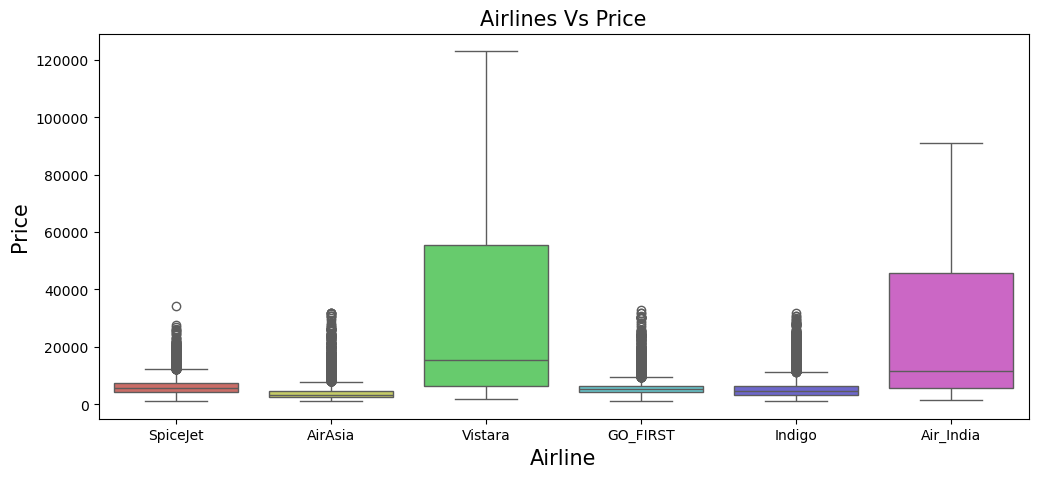

In [25]:
plt.figure(figsize=(12,5))
sns.boxplot(x=raw_df['airline'],y=raw_df['price'],palette='hls')
plt.title('Airlines Vs Price',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

- Maskapai full-service (Vistara, Air India) memiliki harga jauh lebih tinggi

- Maskapai LCC (Indigo, AirAsia, GO_FIRST, SpiceJet) lebih murah & stabil  
🔁 Langkah selanjutnya: maskapai dapat dimasukkan sebagai fitur penting untuk segmentasi/prediksi

Boxplot Harga vs Jumlah Transit (`stops`)

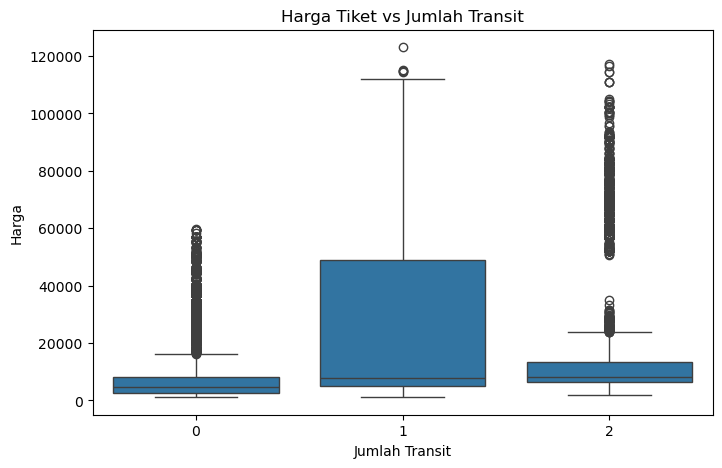

In [26]:
raw_df['stops'] = raw_df['stops'].map({'zero': 0, 'one': 1, 'two_or_more': 2})

plt.figure(figsize=(8, 5))
sns.boxplot(x='stops', y='price', data=raw_df)
plt.title('Harga Tiket vs Jumlah Transit')
plt.xlabel('Jumlah Transit')
plt.ylabel('Harga')
plt.show()


- Penerbangan langsung (0 stop) paling murah

- satu atau lebih transit justru cenderung lebih mahal (bisa karena jarak jauh)  
🔁 Langkah selanjutnya: stops harus dipertahankan sebagai fitur numerik atau kategorikal ordinal

Harga vs Hari Sebelum Keberangkatan (`days_left`)

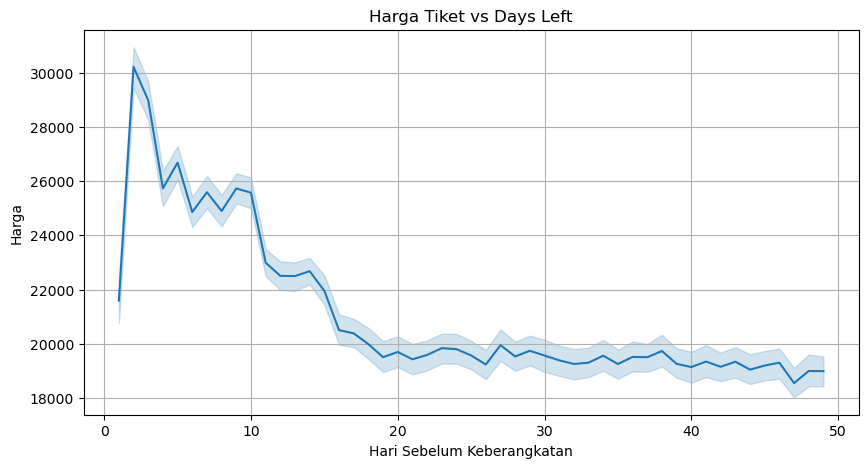

In [27]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='days_left', y='price', data=raw_df)
plt.title('Harga Tiket vs Days Left')
plt.xlabel('Hari Sebelum Keberangkatan')
plt.ylabel('Harga')
plt.grid(True)
plt.show()


- Harga naik tajam saat mendekati hari keberangkatan

- Ada pola menurun stabil saat days_left > 20  
🔁 Langkah selanjutnya:

    - Days left = fitur prediktif kuat, wajib dimasukkan

    - Bisa pertimbangkan strategi notifikasi/diskon berdasar tren ini

Boxplot Harga vs Kelas Penerbangan

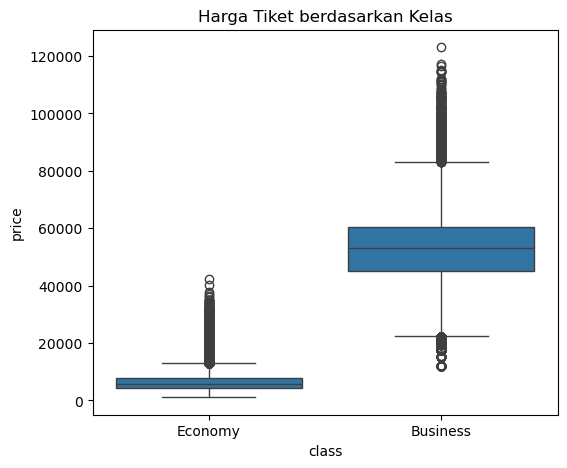

In [28]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='class', y='price', data=raw_df)
plt.title('Harga Tiket berdasarkan Kelas')
plt.xticks([0, 1], ['Economy', 'Business'])
plt.show()


Kelas Bisnis ≫ Kelas Ekonomi (bisa 4–10x lipat)  
🔁 Langkah selanjutnya:

- Pisahkan model Ekonomi & Bisnis untuk hasil prediksi lebih akurat

- Buat visual per kelas untuk evaluasi segmentasi harga

Barplot Rata-rata Harga Tiket per Kota Asal

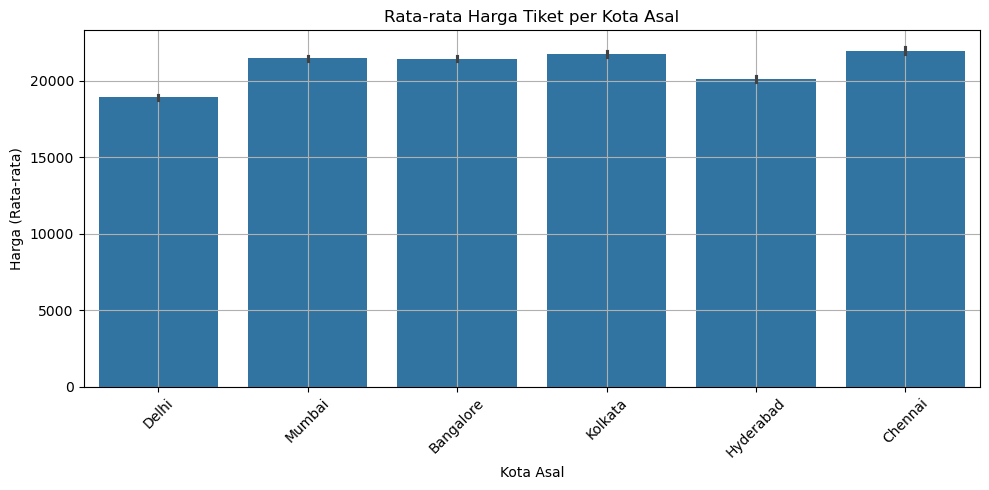

In [29]:
plt.figure(figsize=(10, 5))
sns.barplot(x='source_city', y='price', data=raw_df, estimator='mean')
plt.title('Rata-rata Harga Tiket per Kota Asal')
plt.ylabel('Harga (Rata-rata)')
plt.xlabel('Kota Asal')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Kota tertentu (Delhi) rata-rata lebih murah, kota lain (Kolkata, Chennai) cenderung mahal  
🔁 Langkah selanjutnya:

- Gabungkan source_city + destination_city sebagai “rute”

- Gunakan one-hot encoding agar model bisa tangkap efek geografis

Barplot Rata-rata Harga Tiket per Kota Tujuan

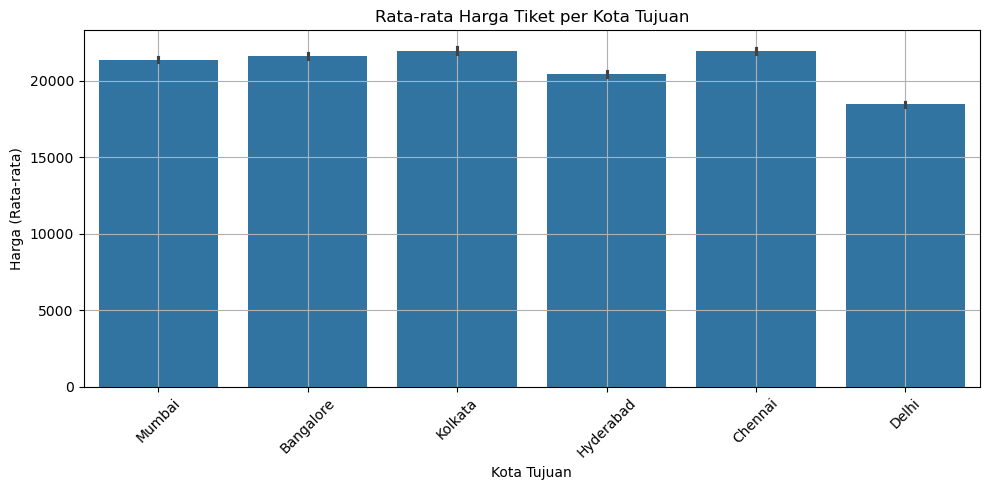

In [30]:
plt.figure(figsize=(10, 5))
sns.barplot(x='destination_city', y='price', data=raw_df, estimator='mean')
plt.title('Rata-rata Harga Tiket per Kota Tujuan')
plt.ylabel('Harga (Rata-rata)')
plt.xlabel('Kota Tujuan')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Kota tertentu (Delhi) rata-rata lebih murah, kota lain (Kolkata, Chennai) cenderung mahal  
🔁 Langkah selanjutnya:

- Gabungkan source_city + destination_city sebagai “rute”

- Gunakan one-hot encoding agar model bisa tangkap efek geografis

Scatterplot Harga vs Durasi Penerbangan

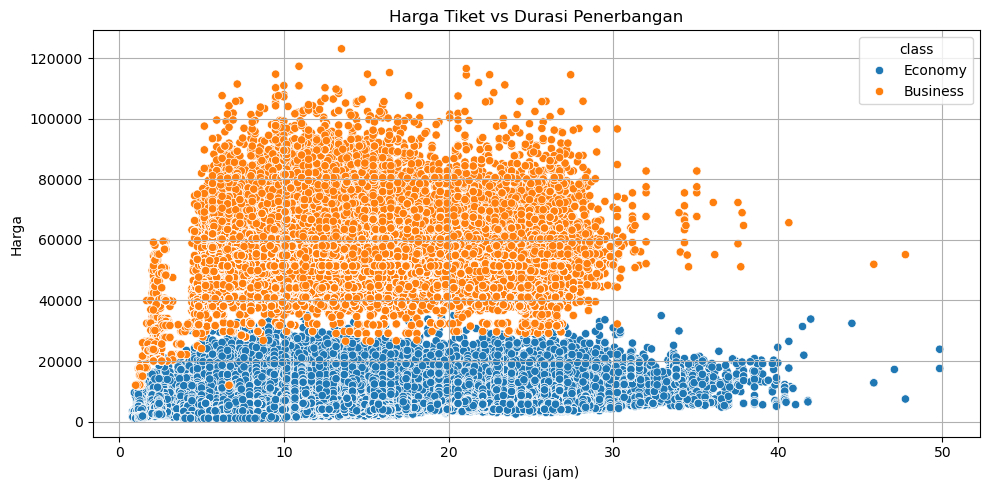

In [31]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='duration', y='price', data=raw_df, hue='class')
plt.title('Harga Tiket vs Durasi Penerbangan')
plt.xlabel('Durasi (jam)')
plt.ylabel('Harga')
plt.grid(True)
plt.tight_layout()
plt.show()


Insight:
- Ada tren umum: semakin lama durasi penerbangan, harga cenderung meningkat

- Tapi: kelas bisnis (orange) harga tetap tinggi meskipun durasi pendek

- Sebaran ekonomi (biru) lebih padat di bawah 15.000 meski durasi bisa 1–10 jam

🔁 Langkah Selanjutnya:
- Fitur duration penting untuk memperkirakan harga, terutama di kelas ekonomi

- Perlu ditangani dengan feature scaling jika pakai model sensitif seperti KNN atau regresi linier

Heatmap Korelasi Antar Variabel Numerik

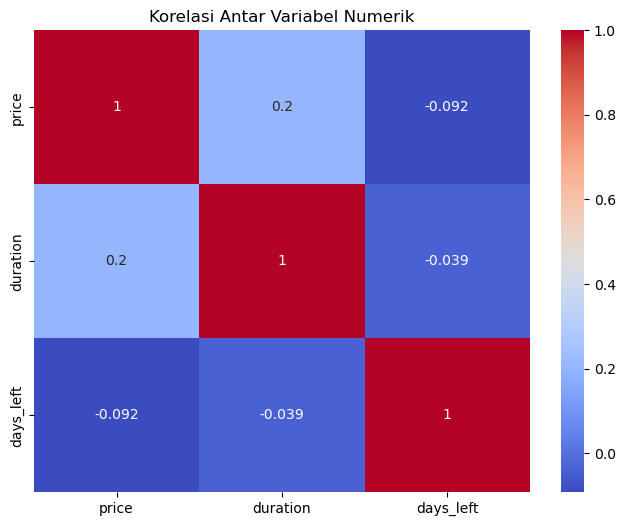

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(raw_df[['price', 'duration', 'days_left']].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variabel Numerik')
plt.show()


**Insight:**
- Korelasi negatif antara `days_left` dan `price` → makin dekat hari H, makin mahal (logis)

- Korelasi positif antara `duration` dan `price` → makin lama penerbangan, makin mahal

- Tidak ada korelasi sangat tinggi (> 0.9), artinya tidak perlu drop fitur

🔁 Langkah Selanjutnya:
- `days_left` dan `duration` adalah fitur numerik kunci

- Keduanya harus tetap digunakan di semua model

- Tidak perlu lakukan feature reduction (PCA) karena tidak ada multikolinearitas tinggi

Lineplot Harga vs Days Left (Per Kelas)

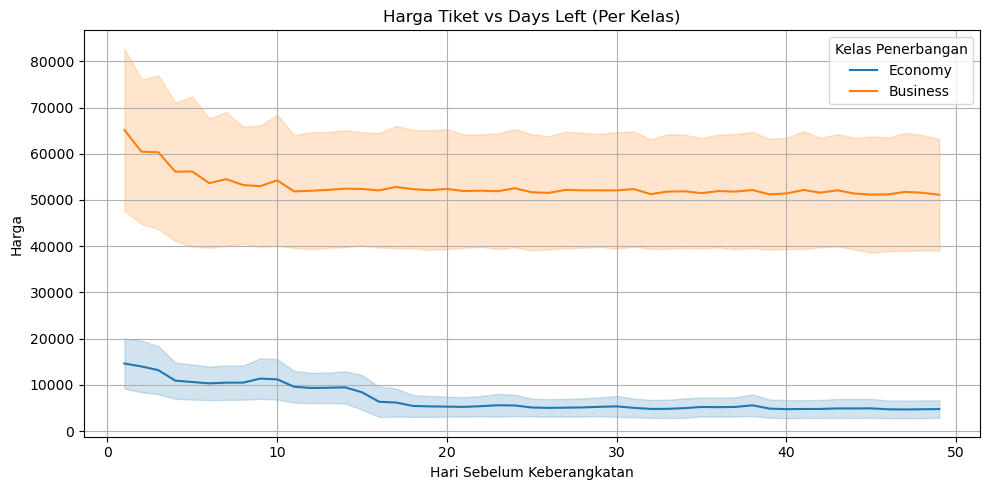

In [33]:
# Cek apakah class berbentuk teks, jika belum ubah
if raw_df['class'].dtype != 'O':  # O = object (string)
    raw_df['class'] = raw_df['class'].map({0: 'Economy', 1: 'Business'})

# Drop baris NaN
raw_df = raw_df.dropna(subset=['days_left', 'price', 'class'])

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='days_left', y='price', data=raw_df, hue='class', ci='sd')
plt.title('Harga Tiket vs Days Left (Per Kelas)')
plt.xlabel('Hari Sebelum Keberangkatan')
plt.ylabel('Harga')
plt.legend(title='Kelas Penerbangan')
plt.grid(True)
plt.tight_layout()
plt.show()


- Ekonomi: harga naik tajam di hari-hari terakhir

- Bisnis: harga tinggi konsisten, tidak terlalu terpengaruh waktu  
🔁 Langkah selanjutnya:

    - Gunakan model prediksi terpisah untuk Ekonomi & Bisnis

    - Ekonomi = model yang memperhatikan days_left secara detail

    - Bisnis = model bisa lebih fokus pada maskapai & rute

# 5: Modeling dan Evaluasi

**Tujuan:**   
  
  - Membangun model machine learning untuk memprediksi harga tiket pesawat (price) berdasarkan fitur yang tersedia
  - lalu mengevaluasi performanya secara kuantitatif dan bisnis.

**Strategi Modeling**
- Model Gabungan (semua data)
    Untuk baseline dan prediksi umum

- Model Terpisah (per kelas: Ekonomi & Bisnis)
    Untuk akurasi lebih tinggi, karena segmen sangat berbeda

## 5.1 Modelling Gabungan

1. Split Data (X vs y)

In [34]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='price')
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


2. Baseline Model (Mean Predictor)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_base = np.full_like(y_test, y_train.mean())

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)


3. Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)


4. Random Forest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)


Tabel Perbandingan

In [38]:
results = pd.DataFrame({
    'Model': ['Baseline (Mean)', 'Linear Regression', 'Random Forest'],
    'MAE': [mae_base, mae_lr, mae_rf],
    'RMSE': [rmse_base, rmse_lr, rmse_rf],
    'R²': [r2_base, r2_lr, r2_rf]
})

results.sort_values(by='R²', ascending=False, inplace=True)
display(results)


,Model,MAE,RMSE,R²
2,Random Forest,1086.811735,2800.957468,9.847805e-01
1,Linear Regression,4500.712502,6814.935635,9.099031e-01
0,Baseline (Mean),19768.478070,22704.235502,-7.013837e-08


## 5.2 Modelling Terpisah

berdasarkan insight bahwa distribusi harga sangat berbeda antara kelas ekonomi dan bisnis (bimodal).  
Maka kita melatih dua model secara terpisah untuk meningkatkan akurasi masing-masing.

1. Pisahkan Data Berdasarkan Kelas

In [39]:
# Pisahkan data berdasarkan kelas
df_eco = df[df['class'] == 0]   # Economy
df_biz = df[df['class'] == 1]   # Business


2. Split Fitur dan Target untuk Masing-Masing

In [40]:
# Economy
X_eco = df_eco.drop(columns='price')
y_eco = df_eco['price']
X_eco_train, X_eco_test, y_eco_train, y_eco_test = train_test_split(X_eco, y_eco, test_size=0.2, random_state=42)

# Business
X_biz = df_biz.drop(columns='price')
y_biz = df_biz['price']
X_biz_train, X_biz_test, y_biz_train, y_biz_test = train_test_split(X_biz, y_biz, test_size=0.2, random_state=42)


3. Latih Random Forest untuk Masing-Masing

In [41]:
rf_eco = RandomForestRegressor(n_estimators=100, random_state=42)
rf_eco.fit(X_eco_train, y_eco_train)
y_eco_pred = rf_eco.predict(X_eco_test)

rf_biz = RandomForestRegressor(n_estimators=100, random_state=42)
rf_biz.fit(X_biz_train, y_biz_train)
y_biz_pred = rf_biz.predict(X_biz_test)


4. Evaluasi Kinerja Masing-Masing Model

In [42]:
# Economy
mae_eco = mean_absolute_error(y_eco_test, y_eco_pred)
rmse_eco = np.sqrt(mean_squared_error(y_eco_test, y_eco_pred))
r2_eco = r2_score(y_eco_test, y_eco_pred)

# Business
mae_biz = mean_absolute_error(y_biz_test, y_biz_pred)
rmse_biz = np.sqrt(mean_squared_error(y_biz_test, y_biz_pred))
r2_biz = r2_score(y_biz_test, y_biz_pred)


5. Tabel Ringkasan Hasil

In [43]:
eval_per_class = pd.DataFrame({
    'Kelas': ['Economy', 'Business'],
    'MAE': [mae_eco, mae_biz],
    'RMSE': [rmse_eco, rmse_biz],
    'R²': [r2_eco, r2_biz]
})

display(eval_per_class)


,Kelas,MAE,RMSE,R²
0,Economy,603.865482,1331.415374,0.870532
1,Business,2085.690514,4455.197673,0.882630


## 5.3 Perbandingan Model

Model Gabungan

| Model                        | MAE       | RMSE      | R²              |
| ---------------------------- | --------- | --------- | --------------- |
| **Gabungan - Random Forest** | **1,086** | **2,801** | **0.985**       |
| Gabungan - Linear Regression | 4,501     | 6,815     | 0.091           |
| Gabungan - Baseline (Mean)   | 19,768    | 22,704    | \~0.0 (negatif) |


Model Terpisah

| Model Per Kelas  | MAE     | RMSE      | R²    |
| ---------------- | ------- | --------- | ----- |
| **Ekonomi (RF)** | **604** | **1,331** | 0.871 |
| **Bisnis (RF)**  | 2,086   | 4,455     | 0.883 |


## 5.4 Cek Overfitting (Train vs Test Evaluation)

### Model Gabungan

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"📌 Evaluasi Model: {name}")
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Training:")
    print("  MAE :", round(mean_absolute_error(y_train, y_train_pred), 2))
    print("  RMSE:", round(mean_squared_error(y_train, y_train_pred, squared=False), 2))
    print("  R²  :", round(r2_score(y_train, y_train_pred), 3))
    
    print("Testing:")
    print("  MAE :", round(mean_absolute_error(y_test, y_test_pred), 2))
    print("  RMSE:", round(mean_squared_error(y_test, y_test_pred, squared=False), 2))
    print("  R²  :", round(r2_score(y_test, y_test_pred), 3))
    print("-" * 40)


In [45]:
evaluate_model("Gabungan - RF", rf, X_train, y_train, X_test, y_test)


📌 Evaluasi Model: Gabungan - RF
Training:
  MAE : 421.24
  RMSE: 1133.57
  R²  : 0.998
Testing:
  MAE : 1086.81
  RMSE: 2800.96
  R²  : 0.985
----------------------------------------


### Model terpisah (Economy - Business)

In [46]:
# Evaluasi model Economy
evaluate_model("Ekonomi - RF", rf_eco, X_eco_train, y_eco_train, X_eco_test, y_eco_test)

# Evaluasi model Business
evaluate_model("Bisnis - RF", rf_biz, X_biz_train, y_biz_train, X_biz_test, y_biz_test)


📌 Evaluasi Model: Ekonomi - RF
Training:
  MAE : 237.71
  RMSE: 543.42
  R²  : 0.979
Testing:
  MAE : 603.87
  RMSE: 1331.42
  R²  : 0.871
----------------------------------------
📌 Evaluasi Model: Bisnis - RF
Training:
  MAE : 832.6
  RMSE: 1875.6
  R²  : 0.979
Testing:
  MAE : 2085.69
  RMSE: 4455.2
  R²  : 0.883
----------------------------------------


| Model             | Dataset | MAE     | RMSE    | R²    |
| ----------------- | ------- | ------- | ------- | ----- |
| **Gabungan - RF** | Train   | 421.24  | 1133.57 | 0.998 |
|                   | Test    | 1086.81 | 2800.96 | 0.985 |
| **Ekonomi - RF**  | Train   | 237.71  | 543.42  | 0.979 |
|                   | Test    | 603.87  | 1331.42 | 0.871 |
| **Bisnis - RF**   | Train   | 832.60  | 1875.60 | 0.979 |
|                   | Test    | 2085.69 | 4455.20 | 0.883 |


## 5.5 Hyperparameter Tuning (Random Forest)

**Tujuan:**
- Mencari kombinasi parameter terbaik untuk meningkatkan akurasi model.
- Menghindari overfitting/underfitting lewat konfigurasi optimal.



**Untuk Random Forest, kita bisa coba parameter ini:**

- n_estimators: jumlah pohon

- max_depth: kedalaman maksimum pohon

- min_samples_split: minimal jumlah sampel untuk split node

### 5.5a GridSearchCV untuk Model Gabungan

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Grid parameter
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

# GridSearch untuk model gabungan
grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf_grid = grid_rf.best_estimator_
print("Best Parameters (Gabungan):", grid_rf.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters (Gabungan): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


### 5.5b GridSearchCV untuk Model Economy

In [48]:
grid_rf_eco = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_rf_eco.fit(X_eco_train, y_eco_train)
best_rf_eco_grid = grid_rf_eco.best_estimator_
print("Best Parameters (Economy):", grid_rf_eco.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters (Economy): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


### 5.5c GridSearchCV untuk Model Business

In [49]:
grid_rf_biz = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_rf_biz.fit(X_biz_train, y_biz_train)
best_rf_biz_grid = grid_rf_biz.best_estimator_
print("Best Parameters (Business):", grid_rf_biz.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters (Business): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [50]:
print(results.columns.tolist())


['Model', 'MAE', 'RMSE', 'R²']


## 5.5d Evaluasi Performa

In [51]:
evaluate_model("Gabungan - RF (Grid)", best_rf_grid, X_train, y_train, X_test, y_test)
evaluate_model("Ekonomi - RF (Grid)", best_rf_eco_grid, X_eco_train, y_eco_train, X_eco_test, y_eco_test)
evaluate_model("Bisnis - RF (Grid)", best_rf_biz_grid, X_biz_train, y_biz_train, X_biz_test, y_biz_test)


📌 Evaluasi Model: Gabungan - RF (Grid)
Training:
  MAE : 608.62
  RMSE: 1541.66
  R²  : 0.995
Testing:
  MAE : 1090.65
  RMSE: 2714.43
  R²  : 0.986
----------------------------------------
📌 Evaluasi Model: Ekonomi - RF (Grid)
Training:
  MAE : 351.28
  RMSE: 785.43
  R²  : 0.956
Testing:
  MAE : 616.61
  RMSE: 1328.85
  R²  : 0.871
----------------------------------------
📌 Evaluasi Model: Bisnis - RF (Grid)
Training:
  MAE : 1184.44
  RMSE: 2516.47
  R²  : 0.962
Testing:
  MAE : 2075.68
  RMSE: 4296.83
  R²  : 0.891
----------------------------------------


| Model                        | MAE (Train) | RMSE (Train) | R² (Train) |
| ---------------------------- | ---------- | ----------- | --------- |
| **Gabungan – Random Forest** | 1.090      | 2.714       | **0.986** |
| Ekonomi – Random Forest      | **616**    | **1.329**   | 0.871     |
| Bisnis – Random Forest       | 2.076      | 4.297       | 0.891     |


| Model                        | MAE (Test) | RMSE (Test) | R² (Test) |
| ---------------------------- | ---------- | ----------- | --------- |
| **Gabungan – Random Forest** | 1.090      | 2.714       | **0.986** |
| Ekonomi – Random Forest      | **616**    | **1.329**   | 0.871     |
| Bisnis – Random Forest       | 2.076      | 4.297       | 0.891     |


### Insight:
- Model gabungan memiliki akurasi keseluruhan terbaik (R² = 0.986) karena terbantu oleh pembeda kuat: class.

    Namun model gabungan tidak cocok untuk memahami perilaku ekonomi dan bisnis secara spesifik.

- Model terpisah memberikan insight granular yang sangat berguna:

    - Ekonomi: Harga dipengaruhi days_left, cocok untuk sistem alert.

    - Bisnis: Harga dipengaruhi duration, cocok untuk rute panjang.

## 5.5e Visualisasi

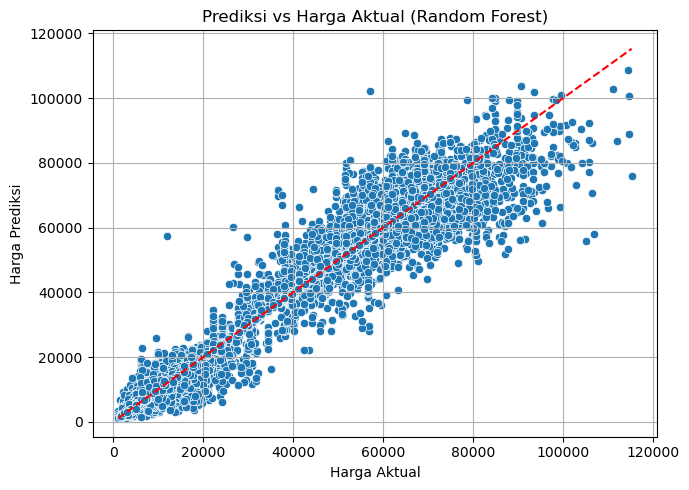

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # garis ideal
plt.xlabel("Harga Aktual")
plt.ylabel("Harga Prediksi")
plt.title("Prediksi vs Harga Aktual (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


1. Scatterplot: Nilai Aktual vs Prediksi

- Titik-titik yang dekat dengan garis merah putus-putus (y = x) menunjukkan prediksi mendekati nilai aktual.

- Penyebaran simetris dan sempit berarti model memprediksi dengan baik untuk berbagai nilai harga.

- Jika muncul banyak titik jauh dari garis, bisa mengindikasikan underfit/overfit di rentang tertentu.

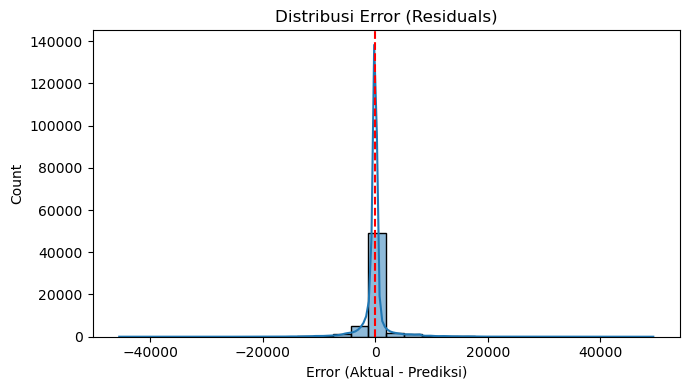

In [53]:
residuals = y_test - y_pred_rf

plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribusi Error (Residuals)")
plt.xlabel("Error (Aktual - Prediksi)")
plt.tight_layout()
plt.show()


2. Residual Plot

- Distribusi residual yang simetris dan terkonsentrasi di sekitar 0 menandakan error kecil dan model stabil.

- Jika distribusinya miring ke kiri/kanan atau memiliki ekor panjang (skewed), berarti model sering over/underpredict.

- Puncak tajam di 0 menandakan prediksi mendekati harga aktual dalam sebagian besar kasus.

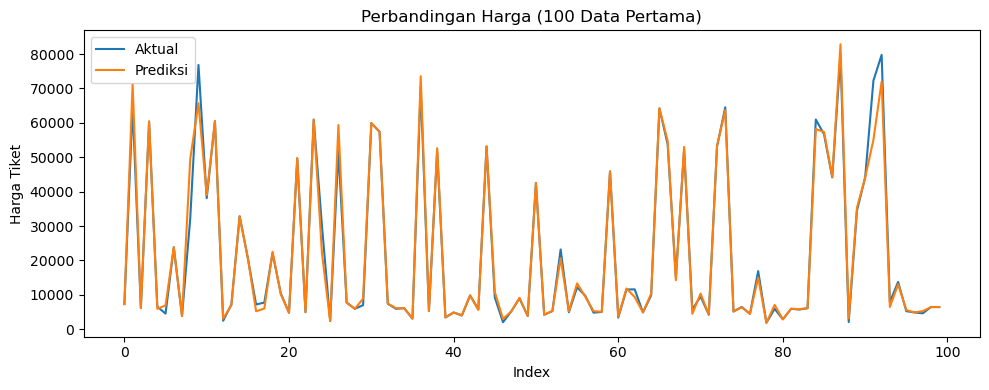

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:100], label='Aktual')
plt.plot(y_pred_rf[:100], label='Prediksi')
plt.title("Perbandingan Harga (100 Data Pertama)")
plt.legend()
plt.xlabel("Index")
plt.ylabel("Harga Tiket")
plt.tight_layout()
plt.show()


3. Lineplot Prediksi vs Aktual (100 Data Pertama)

- Model mengikuti pola umum harga tiket (naik/turun), berarti memahami tren dan variabilitas data.

- Jika garis prediksi terlalu halus → kemungkinan model kurang menangkap fluktuasi tajam.

- Selisih antar garis menunjukkan ketidakakuratan lokal pada titik-titik tertentu.



## 5.6 Interpretasi Model – Feature Importance

Pemilihan model:  

**Model gabungan Random Forest** dipilih sebagai model utama untuk tujuan prediksi harga umum, karena:

- Performanya sangat baik (RMSE: 2.714, R²: 0.986)
- Lebih sederhana untuk deployment
- Sudah menangkap segmentasi kelas melalui fitur `class`

Namun, model terpisah tetap direkomendasikan sebagai tambahan insight untuk analisis strategi harga per segmen dan potensi future improvement seperti:
- Dynamic pricing khusus untuk economy (berbasis waktu beli)
- Optimasi rute bisnis (berbasis durasi dan maskapai)

### Untuk Model Gabungan RF:

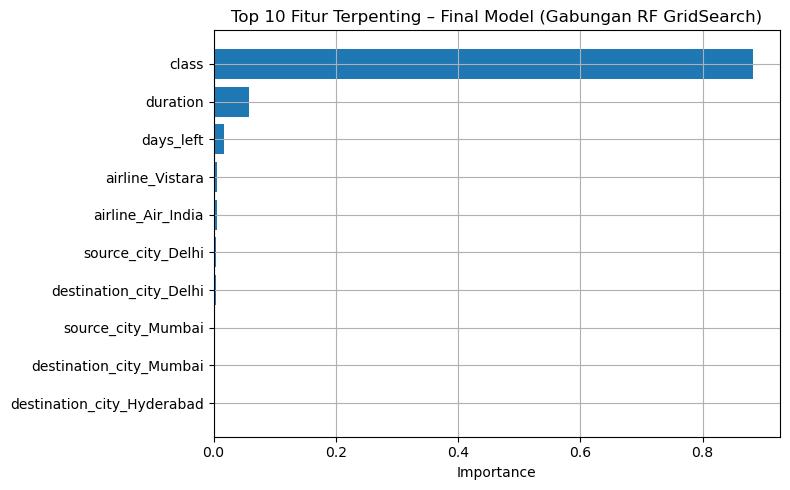

In [55]:
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]  # ambil 10 teratas
    
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Importance")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gabungan
plot_feature_importance(best_rf_grid, X_train.columns, "Top 10 Fitur Terpenting – Final Model (Gabungan RF GridSearch)")



Berdasarkan model final (Random Forest dengan tuning GridSearch), fitur paling berpengaruh terhadap prediksi harga tiket adalah:

- class (kelas penerbangan),

- duration (durasi penerbangan),

- dan days_left (waktu sebelum keberangkatan).

Ini memperkuat insight sebelumnya bahwa kelas penerbangan adalah pembeda utama harga, sedangkan waktu beli dan lama penerbangan menjadi pendorong variabilitas harga dalam satu kelas.

### Save & Deploy

In [56]:
print(best_rf_grid)


RandomForestRegressor(min_samples_split=5, random_state=42)


In [57]:
import joblib

joblib.dump(best_rf_grid, "best_rf_model.joblib", compress=3)


['best_rf_model.joblib']

In [58]:
joblib.dump(list(X_train.columns), "model_features.joblib")


['model_features.joblib']

In [59]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle

# Simpan model
with open("best_rf_model.pkl", "wb") as f:
    pickle.dump(grid_rf.best_estimator_, f)

In [60]:
import pickle

with open("best_rf_model.pkl", "rb") as f:
    model = pickle.load(f)
    

In [61]:
# 2. Simpan model
with open("best_rf_model.pkl", "wb") as f:
    pickle.dump(best_rf_grid, f)

# ✅ 3. Simpan fitur
with open("model_features.pkl", "wb") as f:
    pickle.dump(list(X_train.columns), f)

Hypertuning